In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
from PIL import Image

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse

In [35]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }
DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 22.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }
numpix = 64
#print(util.merge_dicts(DES_camera, DES_g_band_obs))
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_numerics = {'point_source_supersampling_factor': 1}
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [36]:
#Fundamental plane relations and k-correction

def apparent_magnitude(sigma, z, k):
    #sigma = velocity of dispersion [km/s], z = redshift, k = k correction
    a, b = 2.24, 5.47 #Values found for the SLAC sample I used
    M_solar = 4.74 #Absolute magnitude of the Sun
    L = 10**(a*np.log10(sigma) + b) #Luminosity in solar units
    M = M_solar - 2.5*np.log10(L) #Absolute magnitude
    m = M + cosmo.distmod(z).value + k #Apparent magnitude
    return(m)

def angular_diameter(sigma, z, m, k):
    #m = apparent magnitude, re [Arc seconds]
    a, b, c = 1.4043, 0.3045, -8.8579 #orthogonal fit for g band
    D = cosmo.angular_diameter_distance(z).to(u.kpc).value
    first = (60*60*180*sigma**a)/(D*np.pi)
    second = (2*np.pi)**(2.5*b)/(1+z)**(10*b)
    third = 10**(b*m - b*k + c)
    re =  (first*second*third)**(1/(1-5*b))
    return(re)

def k_correction(b):
    filter_file = 'k_values/{}_passband.csv'.format(b)
    data = pd.read_csv(filter_file, names=['r', 'z', 'k'],
                           delim_whitespace=True, comment='#')
    function_kcorrection = interp1d(data['z'].values[1:], data['k'].values[1:], 
        fill_value=0.0)
    return(function_kcorrection)

In [37]:
def funcion(z_lens, z_source1, z_source2, sigma ,center_lens, center_source1, center_source2, i):
    # calculation of variables for the lens:
    band = 'g'
    k = k_correction(band)(z_lens)
    m = apparent_magnitude(sigma, z_lens, k)
    re = angular_diameter(sigma, z_lens, m, k)
    
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [z_lens],  # list of redshift of the deflections
                          #'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [z_source1, z_source2],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source': z_source2} # redshift of the default source (if not further specified by 'source_redshift_list') 
                           #and also serves as the redshift of lensed point sources}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)#, kwargs_numerics=kwargs_numerics)
    sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)#, kwargs_numerics=kwargs_numerics)
    imSim = sim.image_model_class(kwargs_numerics)

    kwargs_mass = [{'sigma_v': sigma, 'center_x': center_lens[0], 'center_y': center_lens[1], 'e1': 0., 'e2': 0.}]
    kwargs_lens = sim.physical2lensing_conversion(kwargs_mass=kwargs_mass)

    #light source and lens
    kwargs_source_mag_g = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': center_source1[0], 'center_y': center_source1[1]},
                      {'magnitude': 23, 'R_sersic': 0.3, 'n_sersic': 1.5, 'center_x': center_source2[0], 'center_y': center_source2[1]}]
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    
    image_g = imSim.image(kwargs_lens, kwargs_source_g)
    image_g += sim.noise_for_model(model=image_g)

    plt.matshow(np.log10(image_g))
    plt.savefig('Image' + str(i) + '.png')

/home/jimenagonzalez/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


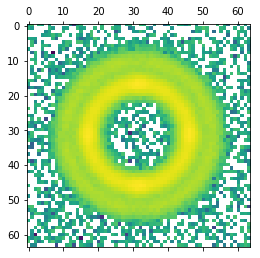

In [38]:
z_lens = .4
z_source1 = 1.
z_source2 = 3.5
dispersion = 500
center_lens = [0,0]
center_source1 = [0,0]
center_source2 = [0,0]
funcion(z_lens, z_source1, z_source2, dispersion, center_lens, center_source1, center_source2, 1)

/home/jimenagonzalez/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


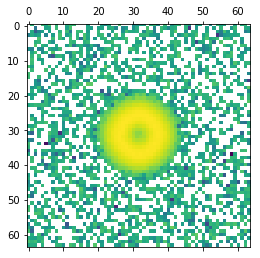

In [39]:
z_lens = .4
z_source1 = 1.
z_source2 = 3.5
dispersion = 300
center_lens = [0,0]
center_source1 = [0,0]
center_source2 = [0,0]
funcion(z_lens, z_source1, z_source2, dispersion, center_lens, center_source1, center_source2, 1)